In [1]:
import csv
import datetime
import operator
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import load_house

from io import StringIO
from matplotlib import rcParams
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA


# Don't cut xlabel when saving .fig
rcParams.update({'figure.autolayout': True})

# Convert datetime for matplotlib
register_matplotlib_converters()

# Create directory for matplotlib figures
if not os.path.exists('plot/ARIMA'):
    os.makedirs('plot/ARIMA')

In [2]:
#channels, labels = REDD(1)
channels, labels = load_house.SMART('2016')

In [3]:
# ARMA and ARIMA forecast
periods_predicted = 30
test_frequency = 'D'
test_start = '2016-01-01'
test_end = '2016-06-01'

def get_aggr_cons(start, end, frequency):
    """Runs a query for the aggregated consumption in all channels in the specified period.
    
    Args:
        start (str): start of the period as "YYYY-MM-DD hh:mm:ss".
        end (str): end of the period as "YYYY-MM-DD hh:mm:ss".
        frequency (str): Period of consumption. 'D', 'W', or 'M' (daily, weekly or monthly).
    
    Returns:
        str: csv of the query as [index, date, consumption].
    """
    periods = (pd.to_datetime(end) - pd.to_datetime(start)).days
    if frequency == 'W':
        periods /= 7
    if frequency == 'M':
        periods /= 30
    t = pd.date_range(start, periods=periods, freq=frequency)
    energy = pd.DataFrame(0, index=np.arange(periods), columns=['energy'])
    aggr_cons = pd.DataFrame([t, energy]).transpose()
    aggr_cons.columns = ['t', 'energy']
    aggr_cons.t = pd.to_datetime(aggr_cons.t)
    aggr_cons.energy = 0
    
    for i in range(len(channels)):
        # Select the desired period from channel
        ch = channels[i]
        mask = (ch.t >= start) & (ch.t < end)
        ch_period = ch.loc[mask]

        # Find mean consumption by day, week, or month
        cons = ch_period.copy()
        cons = cons.set_index('t')
        cons = cons.groupby(pd.Grouper(freq=frequency)).mean().dropna(how='all')
        cons = cons.reset_index()
        cons = pd.concat([cons.t, cons.pot], axis=1)
        cons.columns = ['t', 'energy']

        # Remove days without consumption data
        cons = cons[~cons.energy.isna()]

        # Convert to kWh
        period_hours = 24
        if frequency == 'W':
            period_hours *= 7
        if frequency == 'M':
            period_hours *= 30
        cons.energy = cons.energy * period_hours / 1e3
        
        aggr_cons['energy'] += cons.energy
    
    aggr_cons.t = aggr_cons.t.dt.date
    return aggr_cons


# Get test data
test = get_aggr_cons(test_start, test_end, test_frequency)

# Get validation data
days_predicted = periods_predicted
days_delta = 1
if test_frequency == 'W':
    days_delta = 7
elif test_frequency == 'M':
    days_delta = 30

validation_start = test.t.iloc[-1] + datetime.timedelta(days=days_delta)
validation_end = validation_start + datetime.timedelta(days=days_delta*periods_predicted)
validation = get_aggr_cons(validation_start, validation_end, test_frequency)

In [4]:
from pmdarima.arima import auto_arima

seasonal = True
season_period = 7
if test_frequency == 'W':
    season_period = 5
    #seasonal = False
elif test_frequency == 'M':
    season_period = 12


stepwise_fit = auto_arima(test.energy, start_p=1, start_q=0, max_p=10, max_q=10, m=season_period,
                          start_P=0, max_P=10, max_Q=10, seasonal=seasonal, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

predicted = stepwise_fit.predict(n_periods=periods_predicted)

Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=733.173, BIC=745.052, Fit time=0.627 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=830.062, BIC=836.002, Fit time=0.015 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=778.518, BIC=790.398, Fit time=0.118 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=713.795, BIC=725.674, Fit time=0.432 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=715.695, BIC=730.544, Fit time=0.726 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=792.638, BIC=801.548, Fit time=0.057 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=715.683, BIC=730.532, Fit time=1.194 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=709.734, BIC=727.553, Fit time=1.990 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=708.696, BIC=729.484, Fit time=1.896 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 2, 7);

5.187737496577983
3.0056122042630924
33.090894504883344
7.422935754082617
2.482754109748517
3.5295542296132028
2.5947502422656834
20.731396863573266
30.380814409834542
3.7071436055564213
2.4192477309604152
16.17367769208994
104.85305692838709
31.120025642095396
8.433912245251308
6.040417983927885
68.88956750058418
44.047229980476786
47.11036084202326
31.211207212372326
0.11231893150957813
13.19670540406166
18.481166357533485
0.0382648882566991
102.48393561205056
111.023847758642
47.40954335492052
55.74172414802301
39.1407882495267
82.35843816285683


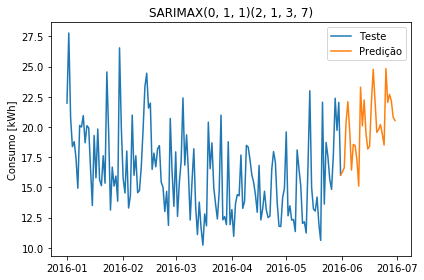

In [5]:
plt.plot(test.t.values, test.energy.values)
plt.plot(np.insert(validation.t.values, 0, test.t.iloc[-1]), np.insert(predicted, 0, test.energy.iloc[-1]))
#plt.plot(validation.t.values, validation.energy.values)

params = stepwise_fit.get_params()
title = 'SARIMAX{}{}'.format(params['order'], params['seasonal_order'])
plt.title(title)
plt.legend(('Teste', 'Predição'))
plt.ylabel('Consumo [kWh]')
plt.savefig('plot/ARIMA/auto-arima.png')
for i in range(periods_predicted):
    sqr_error = (predicted[i] - validation.energy.values[i]) ** 2
    print(sqr_error)

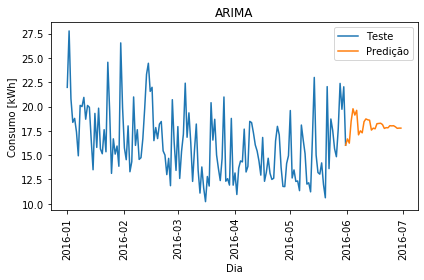

In [6]:
def qry_ARIMA(days_predicted, pdq):
    """Runs a query for the forecast consumption using an ARIMA model.
    
    Args:
        days_predicted (int): number of days to forecast.
        pdq (iterable): order of the model parameters.
    
    Returns:
        str: csv of the query as [index, date, daily forecasted consumption].
    """
    model = ARIMA(test.energy, pdq)
    model_fit = model.fit(disp=0)
    predicted = model_fit.forecast(days_predicted)
    
    # Add daily consumption of current day
    predict_cons = np.insert(predicted[0], 0, test.energy.iloc[-1])
    
    # Convert to pandas.DataFrame
    result = pd.DataFrame(np.transpose([np.insert(validation.t.values, 0, test.t.iloc[-1]), predict_cons]))
    result.columns = ['t', 'energy']
    
    return result.to_csv()


# Plot forecast for 30 days aggregated consumption with ARIMA
query = qry_ARIMA(days_predicted, (7, 1, 2))
predict = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
predict.t = pd.to_datetime(predict.t)

plt.title('ARIMA')
plt.plot(test.t.values, test.energy.values)
plt.plot(predict.t, predict.energy)
plt.legend(('Teste', 'Predição'))
plt.ylabel('Consumo [kWh]')
plt.xlabel('Dia')
plt.xticks(rotation=90)
plt.savefig('plot/ARIMA/arima.png')

/home/tiago/anaconda3/envs/my_env/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


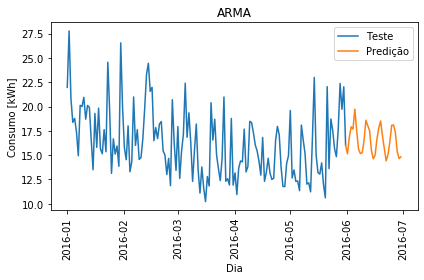

In [7]:
query = qry_ARIMA(days_predicted, (8, 0, 7))
predict = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
predict.t = pd.to_datetime(predict.t)

plt.title('ARMA')
plt.plot(test.t.values, test.energy.values)
plt.plot(predict.t, predict.energy)
plt.legend(('Teste', 'Predição'))
plt.ylabel('Consumo [kWh]')
plt.xlabel('Dia')
plt.xticks(rotation=90)
plt.savefig('plot/ARIMA/arma.png')